In [1]:
import numpy as np
import pandas
import sklearn
import sklearn.linear_model as lm

In [2]:
import matplotlib.pyplot as plt
import spacepy.plot as splot
%matplotlib inline

This unreleased version of SpacePy is not supported by the SpacePy team.


/home/steve/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Okay, we've imported most of what we'll need for our modelling... now load the data

In [3]:
#data file to load is from ftp://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/omni_5min2014.asc
import datetime as dt
data = pandas.read_table('omni_5min2014.asc', delim_whitespace=True, parse_dates=[[0,1,2,3]], header=None, )

In [4]:
#check the column names
data.columns

Index([u'0_1_2_3',          4,          5,          6,          7,          8,
                9,         10,         11,         12,         13,         14,
               15,         16,         17,         18,         19,         20,
               21,         22,         23,         24,         25,         26,
               27,         28,         29,         30,         31,         32,
               33,         34,         35,         36,         37,         38,
               39,         40,         41,         42,         43,         44,
               45,         46,         47,         48],
      dtype='object')

In [5]:
#let's make sure that the aggregated date column looks like it should... YY DOY HH MM
data['0_1_2_3'][0]

u'2014 1 0 0'

## now to set dates...

In [6]:
data['DateTime'] = data['0_1_2_3'].apply(lambda x: dt.datetime.strptime(x, '%Y %j %H %M'))
data.set_index('DateTime', drop=False, inplace=True)

In [7]:
data.rename(columns={17:'By_GSM', 18:'Bz_GSM'}, inplace=True)
data.rename(columns={13:'Btot', 14:'Bx', 15:'By_GSE', 16: 'Bz_GSE'}, inplace=True)
data.rename(columns={21: 'FlowSpeed', 25: 'ProtonDensity', 41: 'Sym-H'}, inplace=True)

In [8]:
#mask bad data
data['FlowSpeed'].mask(data['FlowSpeed']>1200., inplace=True)
data['Btot'].mask(data['Btot']>999., inplace=True)
data['ProtonDensity'].mask(data['ProtonDensity']>999., inplace=True)
data['By_GSM'].mask(data['By_GSM']>60., inplace=True)
data['By_GSM'].mask(data['By_GSM']<-60., inplace=True)
data['Bz_GSM'].mask(data['Bz_GSM']>60., inplace=True)
data['Bz_GSM'].mask(data['Bz_GSM']<-60., inplace=True)

In [9]:
data['Clock'] = pandas.Series(np.tan(data['By_GSM']/data['Bz_GSM']))
data['sin4clock'] = pandas.Series(np.sin(data['Clock'])**4)
data['VB2'] = data['FlowSpeed']*data['Btot']**2
data['Epsilon'] = data['sin4clock']*data['FlowSpeed'].astype(float)*data['Btot'].astype(float)
data['IntEps'] = pandas.rolling_sum(data['Epsilon'], 12, min_periods=3)
data['IntEps'].mask(data['IntEps']>1e5, inplace=True)
data.columns

Index([      u'0_1_2_3',                4,                5,                6,
                      7,                8,                9,               10,
                     11,               12,          u'Btot',            u'Bx',
              u'By_GSE',        u'Bz_GSE',        u'By_GSM',        u'Bz_GSM',
                     19,               20,     u'FlowSpeed',               22,
                     23,               24, u'ProtonDensity',               26,
                     27,               28,               29,               30,
                     31,               32,               33,               34,
                     35,               36,               37,               38,
                     39,               40,         u'Sym-H',               42,
                     43,               44,               45,               46,
                     47,               48,      u'DateTime',         u'Clock',
           u'sin4clock',           u'VB2',       u'E

## Now make the classification to train/test on

In [10]:
data['StormTime'] = 0
data['StormTime'].mask(data['Sym-H']<-30, other=1, inplace=True)

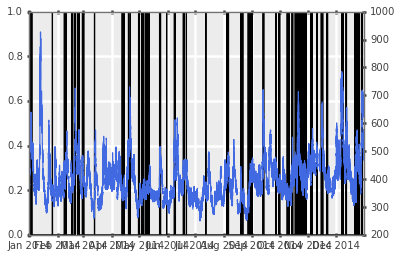

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot('DateTime', 'StormTime', data=data, color='k')
ax2 = ax.twinx()
ax2.plot('DateTime', 'FlowSpeed', data=data)
ax2.grid(False)

## Fit the model

In [39]:
#split data into training and test
nt = int(len(data['Sym-H'])/2)
train = data[:nt]
train = train.dropna(subset = ['Sym-H', 'FlowSpeed', 'StormTime', 'By_GSM', 'Bz_GSM', 'Btot', 'Bx','IntEps'])
test = data[nt:]
test = test.dropna(subset = ['Sym-H', 'FlowSpeed', 'StormTime', 'By_GSM', 'Bz_GSM', 'Btot', 'Bx', 'IntEps'])
featurelist = ['Bz_GSM', 'Btot', 'FlowSpeed', 'IntEps']

In [40]:
lr_model = lm.LogisticRegressionCV(solver='lbfgs') #instantiate model object
lr_model.fit(train[featurelist], train['StormTime'])

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [41]:
predict = lr_model.predict(test[featurelist])

In [42]:
from sklearn.metrics import confusion_matrix, roc_curve
cm = confusion_matrix(test['StormTime'], predict)
print(cm)

[[39861   607]
 [ 2426   352]]


In [43]:
mcf = 1-float(sum(test['StormTime']))/len(test['StormTime'])
print('Majority class fraction is {}'.format(mcf))

Majority class fraction is 0.935762845119


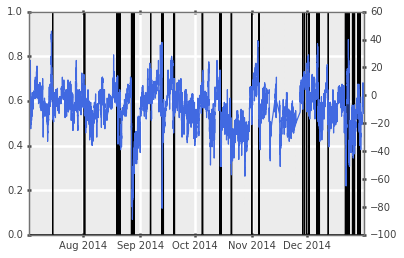

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.asarray(test['DateTime']), predict, color='k')
ax2 = ax.twinx()
ax2.plot(np.asarray(test['DateTime']), np.asarray(test['Sym-H']))
ax2.grid(False)

In [45]:
y_pred_rt = lr_model.predict_proba(test[featurelist])[:,1]

In [46]:
fpr, tpr, _ = roc_curve(test['StormTime'], y_pred_rt)

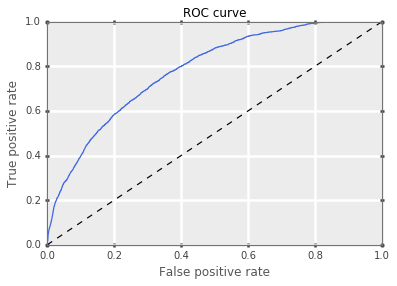

In [47]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

## Analyse the classification skill

In [48]:
import verify

In [49]:
ctable = verify.Contingency2x2(cm)

In [50]:
ctable.summary(True)

Summary Statistics
Bias: 0.956984416014
FAR: 0.0149995057823
PC: 0.92986634602
POFD: 0.632950990615
POD: 0.942630122733

Skill Scores
HeidkeScore: 0.160715656633
PeirceScore: 0.309679132118
ThreatScore: 0.929290809903


# Our model is better than the majority classifier, but not much... try improving the model features

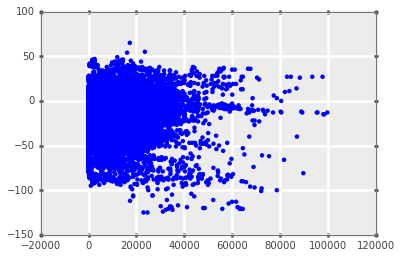

In [38]:
plt.scatter('IntEps', 'Sym-H', data=data)